# Data Collection

## Loading Dataset
This notebook has been developed through Kaggle to use the Common Voice dataset, a corpus of speech data. Here, we just load into a Pandas dataframe one of the available csv files. <br>

Our goal is to train a classifier that detects the age of a person based on his/her voice. <br>

[Here](https://www.kaggle.com/mozillaorg/common-voice?select=README.txt), you can find more info about the dataset!

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")
df[df['age'].notna()].head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


<br>

## Data Exploration
Let's draw some plots to explore the Common Voice dataset. We can notice that the dataset is imbalanced. However, in this notebook, we do not implement any data balancing technique.

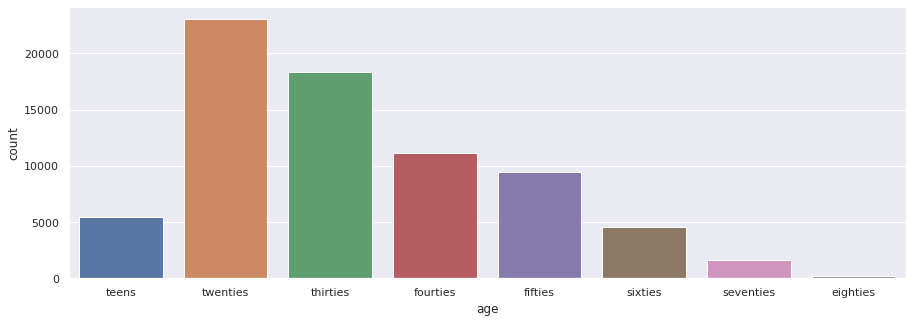

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})

sns.countplot(x="age", 
        data=df[df['age'].notna()], 
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

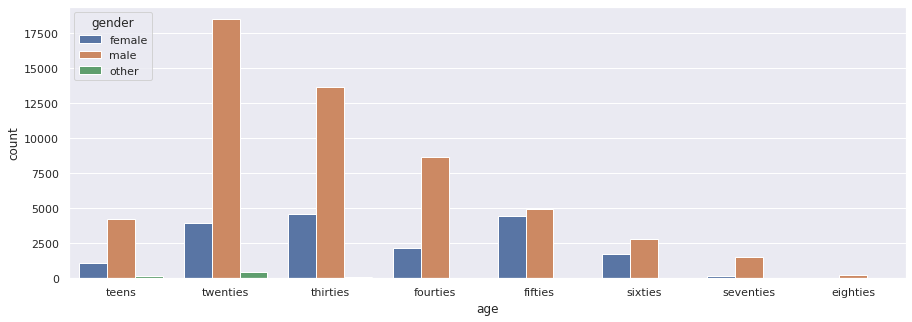

In [3]:
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

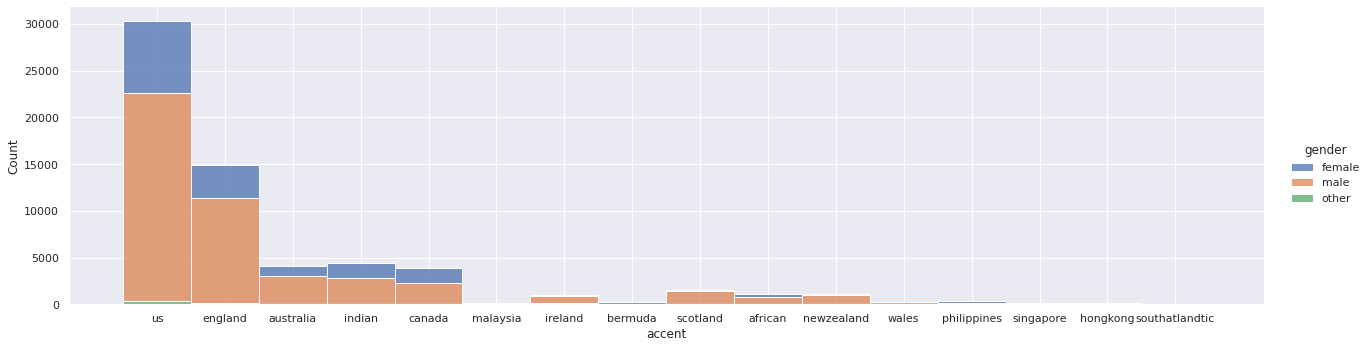

In [4]:
sns.displot(x="accent", 
        data=df[df['accent'].notna()], 
        hue='gender',
        multiple='stack',
        height=5, aspect=18/5)

plt.show()

<br><hr>

# Data Pre-Processing

## Data Cleaning

Drop the entries with NaN values under the columns AGE and/or GENDER.

In [5]:
df = df[['filename', 'age', 'gender']]
df = df[df['age'].notna() & df['gender'].notna()]
df.reset_index(inplace=True, drop=True)
df.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female
3,cv-valid-train/sample-000014.mp3,sixties,male
4,cv-valid-train/sample-000019.mp3,fifties,male


<br>

## Data Transformation

Convert the string GENDER into a float.

In [6]:
def transform_gender(g):
    return {
        "male": 1,
        "other": 0.5,
        "female": 0
    }[g]

df['gender'] = df['gender'].map(lambda x: transform_gender(x))
df.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,0.0
1,cv-valid-train/sample-000008.mp3,seventies,1.0
2,cv-valid-train/sample-000013.mp3,thirties,0.0
3,cv-valid-train/sample-000014.mp3,sixties,1.0
4,cv-valid-train/sample-000019.mp3,fifties,1.0


<br><hr>

# Feature Engineering

## Feature Extraction

We extract the following features:
* **Gender**
* **Spectral Centroid**: each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame
* **Spectral Bandwidth**: compute 2nd-order spectral bandwidth
* **Spectral Rolloff**: the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below
* **Mel Frequency Cepstral Coefficients (MFCCs)**: a small set of 20 features that describe the overall shape of a spectral envelope

In [7]:
import numpy as np
import librosa
ds_path = "/kaggle/input/common-voice/cv-valid-train/"

def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = df[df['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
        
features = feature_extraction(df.iloc[0]['filename'])
print("features: ", features)

features:  [0.0, 2679.9395691628692, 3347.669488765762, 5745.486745886655, -625.21814, 111.32094, 6.326994, 34.757614, 31.619902, -4.7146454, -0.48603043, -4.9340243, -12.714733, -2.0551484, -3.741118, -10.702964, -11.202637, -12.003523, -8.489579, -5.463276, -4.9542165, -3.7151985, -6.3305287, -6.3384733]


In [8]:
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 25001
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "label"])

df_features = create_df_features(df)
df_features.head()

25000/73465

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.0,2679.939569,3347.669489,5745.486746,-625.218140,111.320938,6.326994,34.757614,31.619902,-4.714645,...,-10.702964,-11.202637,-12.003523,-8.489579,-5.463276,-4.954216,-3.715199,-6.330529,-6.338473,twenties
1,1.0,2859.467798,2576.661658,4912.241181,-469.897675,126.299873,-16.546747,3.553606,2.178287,13.770478,...,-10.987108,1.146531,6.103549,-1.724739,-1.226475,-6.429198,-7.261916,-4.788060,-3.121077,seventies
2,0.0,1976.049163,1830.611037,3344.301008,-418.205048,147.668320,-49.972744,-2.285531,37.187012,-8.904264,...,-13.845863,-9.927490,-7.871619,-5.473860,-2.295655,-6.554991,-5.206914,-0.407431,-3.882371,thirties
3,1.0,2333.782018,2533.276030,4398.731436,-464.911224,118.436134,19.749296,27.143938,26.439018,2.309576,...,-5.458494,-2.907650,-4.495940,-2.715731,-0.079105,-5.292979,-5.866175,0.601412,-3.376775,sixties
4,1.0,2351.958974,2974.758776,4743.172457,-343.828766,157.151764,7.660183,41.900478,-15.153757,28.925409,...,0.101646,6.319596,-1.603062,3.837600,-2.643968,2.324786,-1.382977,3.790324,-3.534814,fifties


<br>

## Feature Transformation

Scaling the features with the scikit-learn StandardScaler.

In [9]:
from sklearn.preprocessing import StandardScaler

def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 0:-1], dtype = float))
    # with data.iloc[:, 0:-1] we don't consider the label column
        
    return scaled_data, scaler

x, scaler = scale_features(df_features)

In [10]:
print("Before scaling:", df_features.iloc[0].values[:-1])
print("\nAfter scaling:", x[0])

Before scaling: [0.0 2679.9395691628692 3347.669488765762 5745.486745886655
 -625.2181396484375 111.32093811035156 6.326993942260742 34.75761413574219
 31.619901657104492 -4.7146453857421875 -0.4860304296016693
 -4.934024333953857 -12.714733123779297 -2.0551483631134033
 -3.7411179542541504 -10.702963829040527 -11.20263671875
 -12.003522872924805 -8.489579200744629 -5.463275909423828
 -4.954216480255127 -3.715198516845703 -6.330528736114502
 -6.338473320007324]

After scaling: [-1.72725589 -0.26096243  0.70778969  0.16365521 -1.99125668 -0.21090624
  0.48722826  0.77713746  1.69135008 -0.86671732  0.17104629 -0.27961469
 -1.08791753  0.45905708 -0.02350554 -1.18240869 -1.70576067 -1.32720474
 -1.17530887 -0.56210569 -0.37478236 -0.49750841 -1.03117575 -0.65351927]


In [11]:
from sklearn.preprocessing import LabelEncoder

def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    return labels, encoder

y, encoder = get_labels(df_features)
classes = encoder.classes_
print("Before encoding:", df_features.iloc[0].values[-1])
print("\nAfter encoding:", y[0])
print("\nClasses:", classes)

Before encoding: twenties

After encoding: 7

Classes: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']


<br>

## Feature Selection
We use the ANOVA (ANalysis Of VAriance) statistical technique (f_classif) to select the best 22 features.

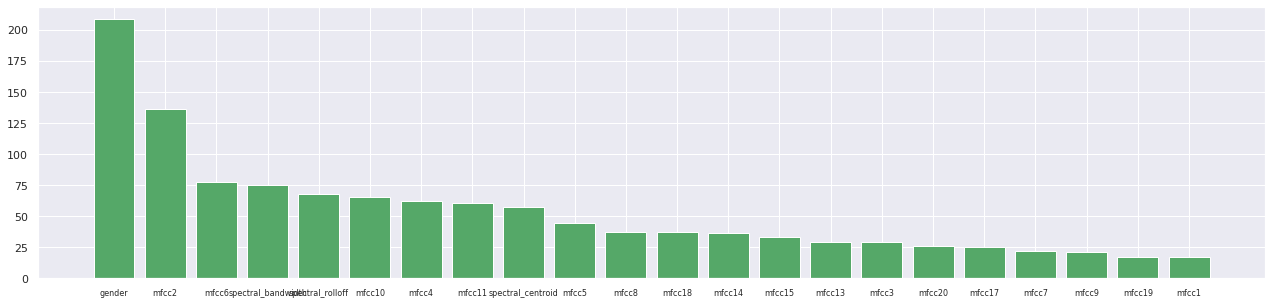

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

n_features = 22

f_selector = SelectKBest(f_classif, k=n_features).fit(x, y)
X_new = f_selector.transform(x)
scores = f_selector.scores_

indices = np.argsort(scores)[::-1]

features = []
for i in range(n_features):
    features.append(df_features.columns[indices[i]])
    
plt.figure(figsize=(22, 5))
plt.bar(features, scores[indices[range(n_features)]], color='g')
plt.xticks(fontsize=8)
plt.show()

<br><hr>

# Model Selection
Here, we consider two classifiers:
* Support Vector Machine
* Random Forest

We evaluate them with the K-Fold Cross-Validation technique. At each iteration of this outer cross-validation process, we tune the hyper-parameters of the classifiers with another (inner) Cross-Validation process , that will further divide the training set into training and validation data. <br>

At each iteration of the outer CV process, we print the F1-Score obtained by the tuned classifier on the validation data, but also the F1-Score computed on the test data. Finally, we print the average F1-Scores computed on the test data at each step of the outer CV process.

In [13]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifiers_and_params = [
    (SVC(), {'C': [200, 150, 100], 'gamma': ['auto', 'scale']}),
    (RandomForestClassifier(), {'n_estimators': [100, 150, 200]})
]

for tup in classifiers_and_params:
    print("{}".format(tup[0].__class__.__name__))
    
    # the main CV process
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    fold_counter = 0

    results = list()
    for train_idx, test_idx in outer_cv.split(X_new):
        fold_counter += 1
        
        # split data in training and test sets
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # the CV process used for the Grid Search
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)

        model = RandomForestClassifier(random_state=0)

        # define and run the Grid Search CV process
        gs = GridSearchCV(tup[0], tup[1], scoring='f1_macro', cv=inner_cv, refit=True)
        res = gs.fit(X_train, y_train)

        # get the best model, re-fit on the whole training set
        best_model = res.best_estimator_

        # evaluation on the test set
        pred = best_model.predict(X_test)
        score = f1_score(y_test, pred, average='macro')
        results.append(score)
        
        print("\tFold {}, Best Params {} with F1 Score {:.3f}, F1 Score on Test data {:.3f}"
              .format(fold_counter, res.best_params_, res.best_score_, score))

    print('\tAverage F1 Score on Test Set: {:.3f}\n'.format(np.mean(results)))

SVC
	Fold 1, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.676, F1 Score on Test data 0.750
	Fold 2, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.676, F1 Score on Test data 0.760
	Fold 3, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.684, F1 Score on Test data 0.758
	Average F1 Score on Test Set: 0.756

RandomForestClassifier
	Fold 1, Best Params {'n_estimators': 150} with F1 Score 0.535, F1 Score on Test data 0.613
	Fold 2, Best Params {'n_estimators': 100} with F1 Score 0.523, F1 Score on Test data 0.615
	Fold 3, Best Params {'n_estimators': 150} with F1 Score 0.550, F1 Score on Test data 0.616
	Average F1 Score on Test Set: 0.615



<br><hr>

# Model Analysis
Finally, we compute the Confusion Matrix obtained with the best model. In this way, we can see how the different labels are confused by this model. 

In [14]:
import itertools
import matplotlib.pyplot as plt

def my_plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix (without normalization)"
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title(title)

    thresh = cm.max() / 2.
    fmt = "{:0.2f}" if normalize else "{:d}"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

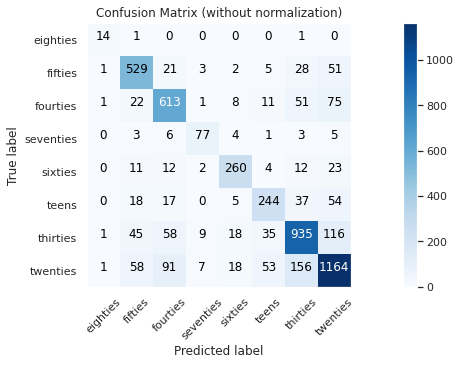

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

model = SVC(C=100, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
my_plot_confusion_matrix(cm, classes=classes)

plt.grid(False)
plt.show()

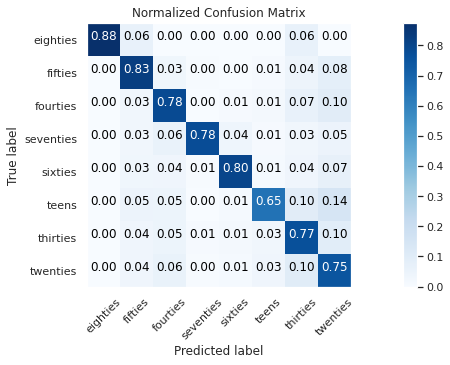

In [16]:
# Plot normalized confusion matrix
plt.figure()
my_plot_confusion_matrix(cm, classes=classes, normalize=True)

plt.grid(False)
plt.show()